In [135]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.basemap import Basemap


In [136]:
# Define start and end date
start_date = "1991-01-01"
end_date = "2014-12-31"

clim = 'miroc6'
x = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/x.pt', weights_only = False).to('cpu').squeeze(-1).numpy()
y = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/y.pt', weights_only = False).to('cpu').squeeze(-1).numpy()
xt = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/ep40/xt.pt', weights_only = False)

time = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/time.pt', weights_only = False)

In [177]:
## this block filters 'y' based on 'x' calender

x_time_np = np.array([pd.Timestamp(str(t)) for t in time])
x_time_np = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in x_time_np], dtype='datetime64[D]')
# Generate a daily time array following the standard Gregorian calendar
y_time = pd.date_range(start=start_date, end=end_date, freq="D")

# Convert to NumPy array for indexing and comparison
y_time_np = y_time.to_numpy()

# Find indices where observed time matches model time
matched_indices = np.where(np.isin(y_time_np, x_time_np))[0]

y = y[matched_indices,:]

### Season Filtering

In [176]:
# Function to determine season from month
def get_season(month):
    if month in [3, 4, 5]:
        return "Spring" #MAM
    elif month in [6, 7, 8]:
        return "Summer" #JJA
    elif month in [9, 10, 11]:
        return "Autumn" #SON
    elif month in [12, 1, 2]:
        return "Winter" #DJF

def load_seasonal_data(time_series, data):
    months = pd.to_datetime(time_series).month  # Extract months from time series
    seasons = np.array([get_season(m) for m in months])  # Assign seasons
    
    seasonal_data = {
        "Spring": data[seasons == "Spring"],
        "Summer": data[seasons == "Summer"],
        "Autumn": data[seasons == "Autumn"],
        "Winter": data[seasons == "Winter"]
    }
    
    return seasonal_data

y_s = load_seasonal_data(x_time_np, y)
x_s = load_seasonal_data(x_time_np, x)
xt_s = load_seasonal_data(x_time_np, xt)

In [ ]:
DEFAULT_THRESHOLDS = {
    "Dry Days": (1, np.less_equal),  # Dry days (<= 1 mm)
    "Wet Days >1mm": (1, np.greater),  # Wet days (>1 mm)
    "Very Wet Days >10mm": (10, np.greater),  # Very wet days (>10 mm)
    "Very Very Wet Days >20mm": (20, np.greater)  # Very very wet days (>20 mm)
}



# Function to compute mean bias per coordinate
def compute_mean_bias(mask, x, y, xt):
    if mask is None:
        bias_x = np.mean(x - y, axis=0)
        bias_xt = np.mean(xt - y, axis=0)
    else:
        mask_expanded = np.where(mask, 1, np.nan)  # Convert mask to NaN-based filter
        bias_x = np.nanmean((x - y) * mask_expanded, axis=0)  # Compute mean bias location-wise
        bias_xt = np.nanmean((xt - y) * mask_expanded, axis=0)
    return bias_x, bias_xt

def compute_mean_bias_percentage(mask, x, y, xt):
    if mask is None:
        percent_bias_x = np.mean((x - y) / (y + 1e-6) * 100, axis=0)
        percent_bias_xt = np.mean((xt - y) / (y + 1e-6) * 100, axis=0)
    else:
        mask_expanded = np.where(mask, 1, np.nan)  # Convert mask to NaN-based filter
        percent_bias_x = np.nanmean(((x - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)  # Compute mean percentage bias location-wise
        percent_bias_xt = np.nanmean(((xt - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)
    return percent_bias_x, percent_bias_xt

# Function to compute bias in the number of days per category
def compute_day_bias(threshold, x, y, xt, comparison):
    count_x = np.sum(comparison(x, threshold), axis=0)  # Count occurrences in raw data
    count_xt = np.sum(comparison(xt, threshold), axis=0)  # Count occurrences in corrected data
    count_y = np.sum(comparison(y, threshold), axis=0)  # Reference count
    return count_x - count_y, count_xt - count_y

# Function to compute percentage bias in the number of days per category
def compute_day_bias_percentage(threshold, x, y, xt, comparison):
    count_x = np.sum(comparison(x, threshold), axis=0)
    count_xt = np.sum(comparison(xt, threshold), axis=0)
    count_y = np.sum(comparison(y, threshold), axis=0)
    percent_x = ((count_x - count_y) / (count_y + 1e-6)) * 100  # Avoid division by zero
    percent_xt = ((count_xt - count_y) / (count_y + 1e-6)) * 100
    return percent_x, percent_xt

def compute_mae(mask, x, y, xt):
    if mask is None:
        mae_x = np.mean(np.abs(x - y), axis=0)
        mae_xt = np.mean(np.abs(xt - y), axis=0)
    else:
        mask_expanded = np.where(mask, 1, np.nan)  # Convert mask to NaN-based filter
        mae_x = np.nanmean(np.abs(x - y) * mask_expanded, axis=0)
        mae_xt = np.nanmean(np.abs(xt - y) * mask_expanded, axis=0)
    return mae_x, mae_xt

def compute_rmse(mask, x, y, xt):
    if mask is None:
        rmse_x = np.sqrt(np.mean((x - y) ** 2, axis=0))
        rmse_xt = np.sqrt(np.mean((xt - y) ** 2, axis=0))
    else:
        mask_expanded = np.where(mask, 1, np.nan)  # Convert mask to NaN-based filter
        rmse_x = np.sqrt(np.nanmean((x - y) ** 2 * mask_expanded, axis=0))
        rmse_xt = np.sqrt(np.nanmean((xt - y) ** 2 * mask_expanded, axis=0))
    return  rmse_x, rmse_xt

# Generalized function to compute mean bias for different precipitation categories
def get_mean_biases(x, y, xt, thresholds=DEFAULT_THRESHOLDS):
    return {label: compute_mean_bias(comparison(y, threshold), x, y, xt) 
            for label, (threshold, comparison) in thresholds.items()}

# Generalized function to compute day bias for different precipitation categories
def get_day_biases(x, y, xt, thresholds=DEFAULT_THRESHOLDS):
    return {label: compute_day_bias(threshold, x, y, xt, comparison) 
            for label, (threshold, comparison) in thresholds.items()}

# Generalized function to compute percentage day bias for different precipitation categories
def get_day_bias_percentages(x, y, xt, thresholds=DEFAULT_THRESHOLDS):
    return {label: compute_day_bias_percentage(threshold, x, y, xt, comparison) 
            for label, (threshold, comparison) in thresholds.items()}

# Generalized function to compute mean bias percentage for different precipitation categories
def get_mean_bias_percentages(x, y, xt, thresholds=DEFAULT_THRESHOLDS):
    return {label: compute_mean_bias_percentage(comparison(y, threshold), x, y, xt) 
            for label, (threshold, comparison) in thresholds.items()}

# Generalized function to compute MAE and RMSE for different precipitation categories
def get_rmse(x, y, xt, thresholds=DEFAULT_THRESHOLDS):
    return {label: compute_rmse(comparison(y, threshold), x, y, xt) 
            for label, (threshold, comparison) in thresholds.items()}
def get_mae(x, y, xt, thresholds=DEFAULT_THRESHOLDS):
    return {label: compute_mae(comparison(y, threshold), x, y, xt) 
            for label, (threshold, comparison) in thresholds.items()}

# Compute biases
mean_biases = get_mean_biases(x, y, xt)
day_biases = get_day_biases(x, y, xt)
day_bias_percentages = get_day_bias_percentages(x, y, xt)
mean_bias_percentages = get_mean_bias_percentages(x, y, xt)

## Temporal Analysis

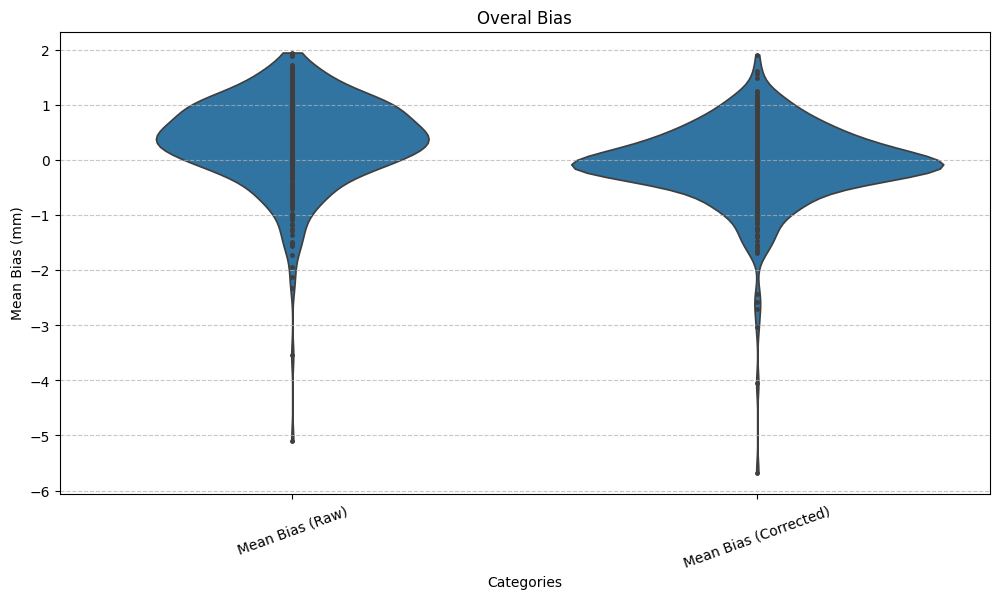

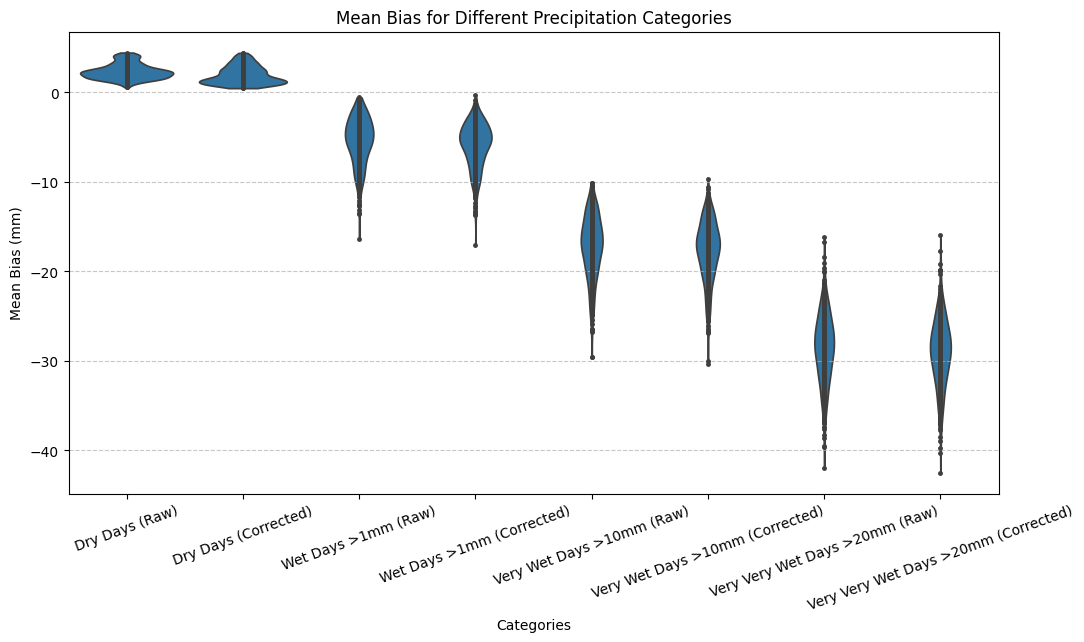

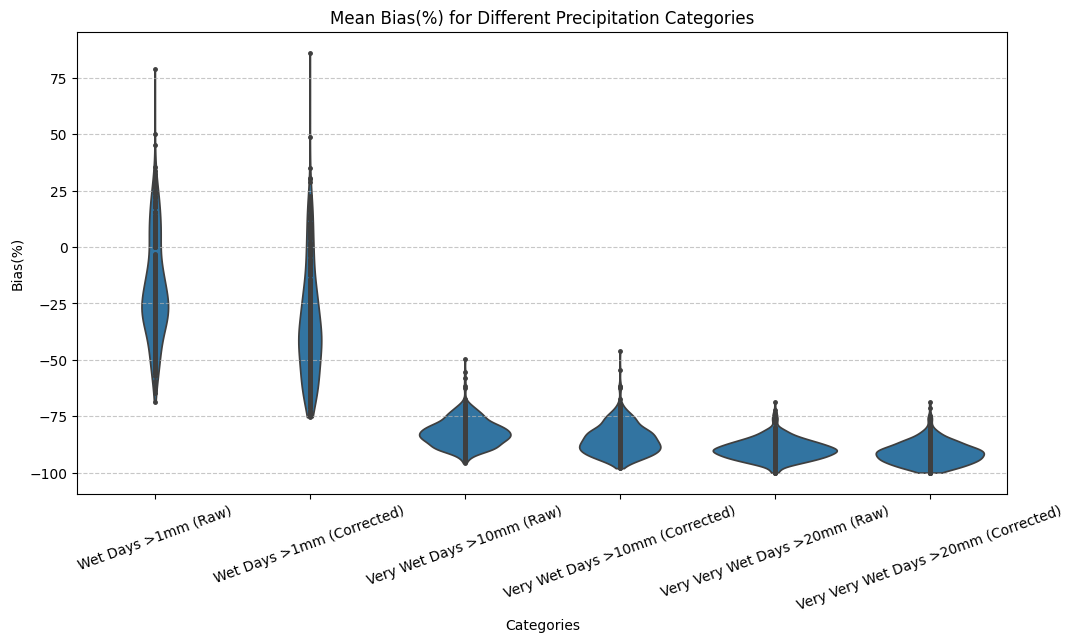

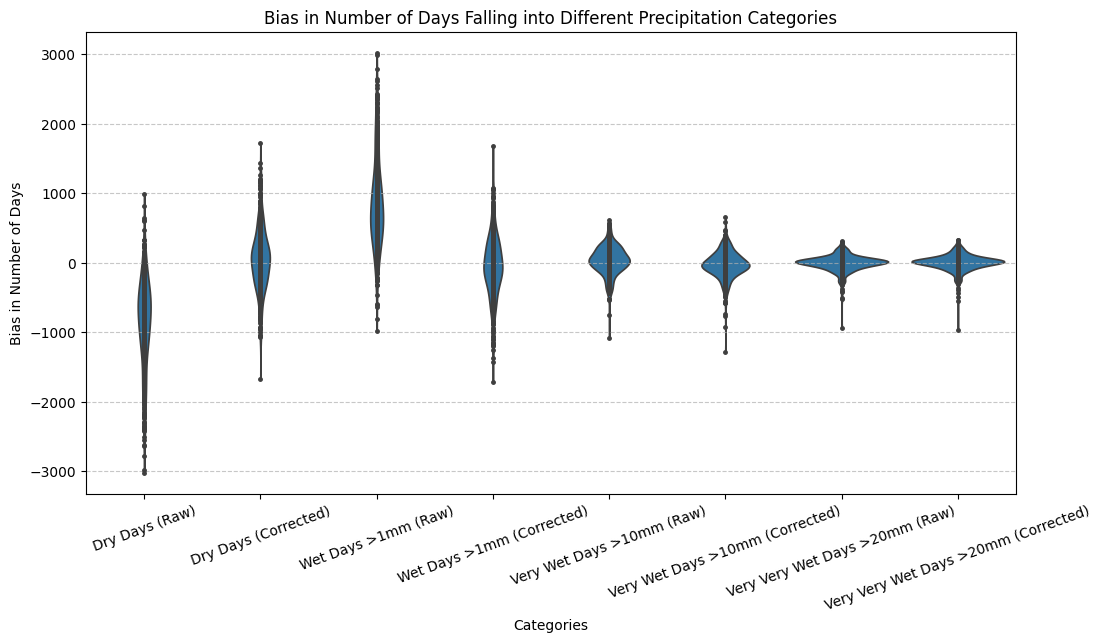

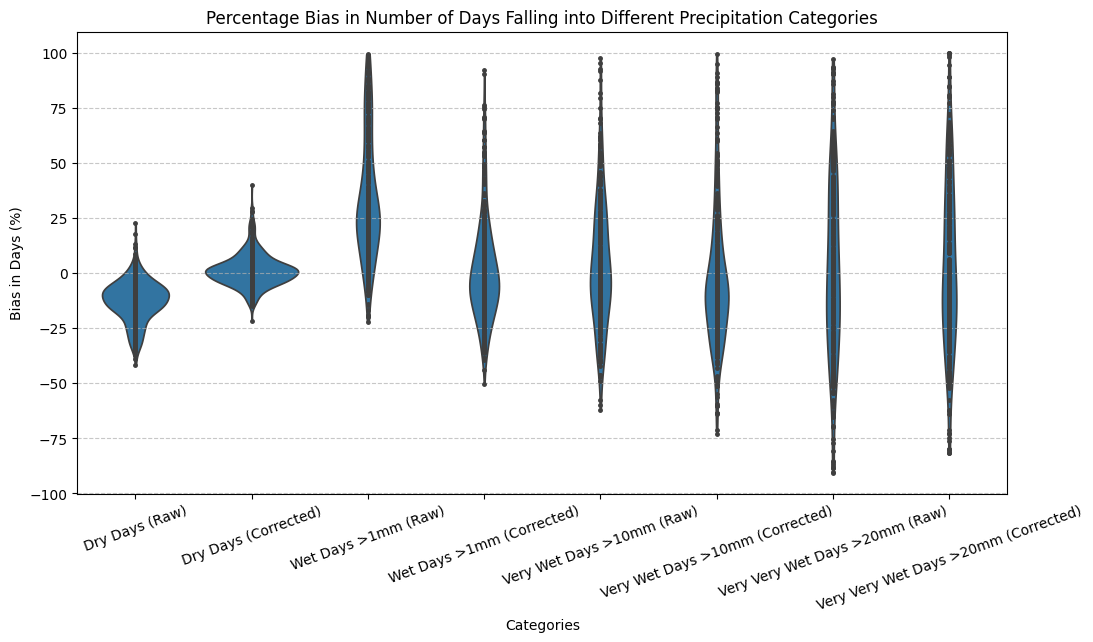

In [204]:
def plot_violin_bias(bias_data, bias_label, title, remove_outlier=False):
    if isinstance(bias_data, dict):
        bias_values, bias_types = [], []
        for label, (bias_raw, bias_corrected) in bias_data.items():
            for bias, sublabel in [(bias_raw, "Raw"), (bias_corrected, "Corrected")]:
                if isinstance(bias, np.ndarray) and bias.size > 0:
                    bias_values.extend(bias.tolist())
                    bias_types.extend([f"{label} ({sublabel})"] * len(bias))
        
        df_bias = pd.DataFrame({bias_label: bias_values, "Type": bias_types})

    else:
        bias_raw, bias_corrected = bias_data
        df_bias = pd.DataFrame({bias_label: np.concatenate([bias_raw, bias_corrected]),
        "Type": (["Mean Bias (Raw)"] * len(bias_raw)) + (["Mean Bias (Corrected)"] * len(bias_corrected))})
        
    
    if remove_outlier:
        df_bias = df_bias[df_bias[bias_label]<100]
        df_bias = df_bias[df_bias[bias_label]>-100]

    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Type", y=bias_label, data=df_bias, inner="point", cut=0)
    plt.title(title)
    plt.ylabel(bias_label)
    plt.xlabel("Categories")
    plt.xticks(rotation=20)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


bias = compute_mean_bias(None, x, y, xt)
plot_violin_bias(bias, "Mean Bias (mm)", "Overal Bias")
    
plot_violin_bias(mean_biases, "Mean Bias (mm)", "Mean Bias for Different Precipitation Categories")
plot_violin_bias(mean_bias_percentages, "Bias(%)", "Mean Bias(%) for Different Precipitation Categories", remove_outlier=True)
plot_violin_bias(day_biases, "Bias in Number of Days", "Bias in Number of Days Falling into Different Precipitation Categories")
plot_violin_bias(day_bias_percentages, "Bias in Days (%)", "Percentage Bias in Number of Days Falling into Different Precipitation Categories",  remove_outlier=True)

## Spatial Analysis

In [141]:
import data.valid_crd as valid_crd
cmip6_dir = '/pscratch/sd/k/kas7897/cmip6'
clim_data = xr.open_dataset(f'{cmip6_dir}/{clim}/historical/precipitation/clipped_US.nc')
valid_coords = valid_crd.valid_lat_lon(clim_data, 'pr')

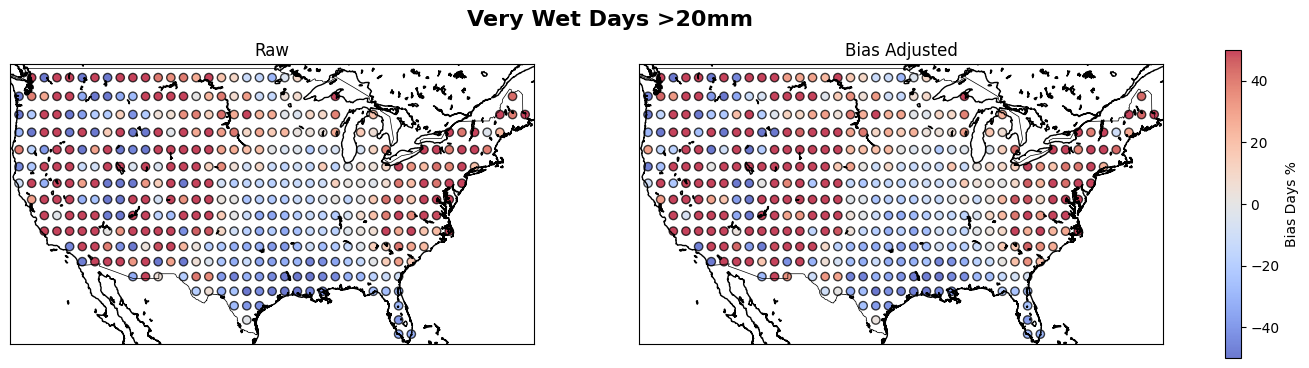

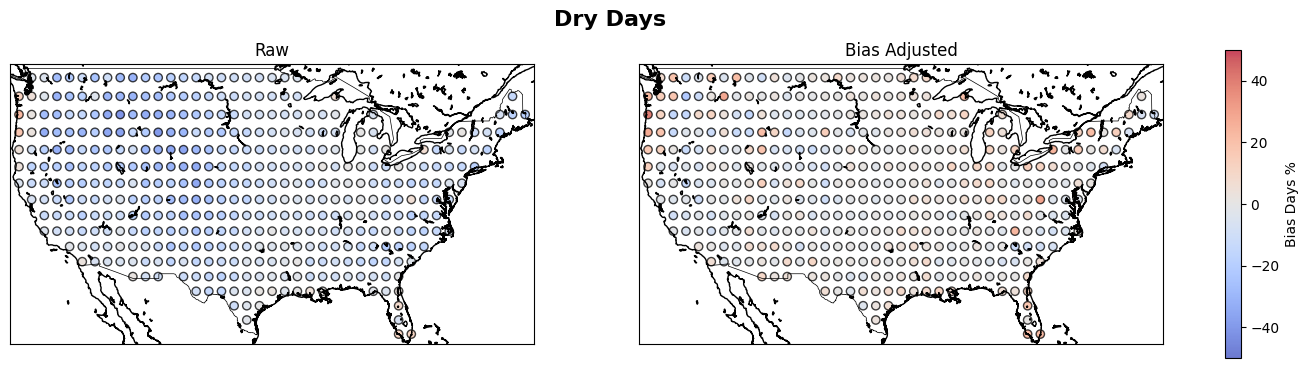

In [ ]:
def plot_spatial_bias(valid_coords, mean_bias_values_array, threshold_type, label, vmin=None, vmax=None):
    lats, lons = zip(*valid_coords)  # Extract latitudes and longitudes
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(threshold_type, fontsize=16, fontweight='bold')

    for ax, mean_bias_values, title in zip(axes, [mean_bias_values_array[threshold_type][0], mean_bias_values_array[threshold_type][1]], ['Raw', 'Bias Adjusted']):
        m = Basemap(projection='merc',
                    llcrnrlat=min(lats)-1, urcrnrlat=max(lats)+1,
                    llcrnrlon=min(lons)-1, urcrnrlon=max(lons)+1,
                    resolution='i', ax=ax)
        m.drawcoastlines()
        m.drawcountries()
        # m.drawparallels(np.arange(int(min(lats)), int(max(lats)), 2), labels=[1,0,0,0], fontsize=10)
        # m.drawmeridians(np.arange(int(min(lons)), int(max(lons)), 2), labels=[0,0,0,1], fontsize=10)
        
        x, y = m(lons, lats)
        sc = m.scatter(x, y, c=mean_bias_values, cmap="coolwarm", marker="o", edgecolor="k", alpha=0.75, vmin=vmin, vmax=vmax)
        
        ax.set_title(title)
        
    
    fig.colorbar(sc, ax=axes, orientation="vertical", fraction=0.02, pad=0.05, label=label)
    plt.show()

plot_spatial_bias(valid_coords, day_bias_percentages, 'Very Wet Days >20mm', label= 'Bias Days %', vmin=-50, vmax=50)
plot_spatial_bias(valid_coords, day_bias_percentages, 'Dry Days', label= 'Bias Days %', vmin=-50, vmax=50)


## Seasonal Analysis

/tmp/ipykernel_602538/1269000951.py:11: RuntimeWarning: Mean of empty slice
  bias_x = np.nanmean((x - y) * mask_expanded, axis=0)  # Compute mean bias location-wise
/tmp/ipykernel_602538/1269000951.py:12: RuntimeWarning: Mean of empty slice
  bias_xt = np.nanmean((xt - y) * mask_expanded, axis=0)
/tmp/ipykernel_602538/1269000951.py:17: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(((x - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)  # Compute mean percentage bias location-wise
/tmp/ipykernel_602538/1269000951.py:18: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(((xt - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)


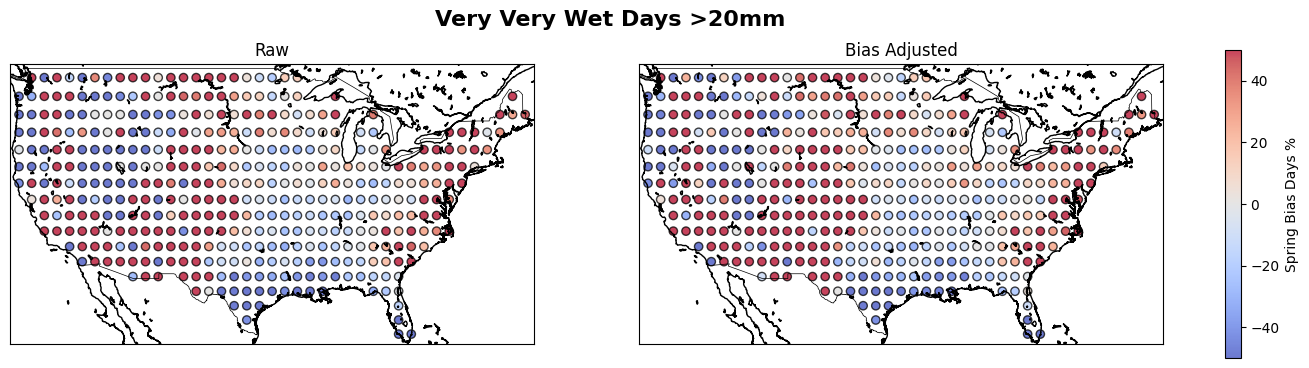

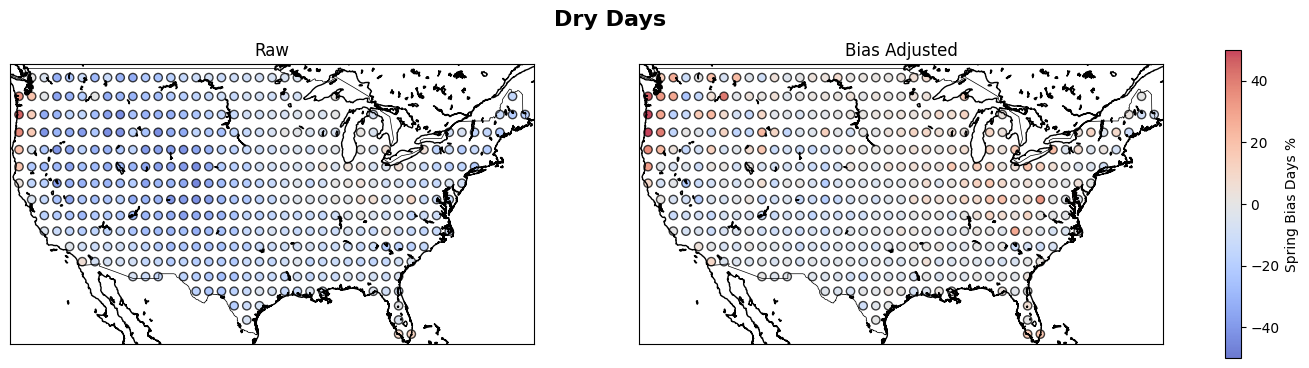

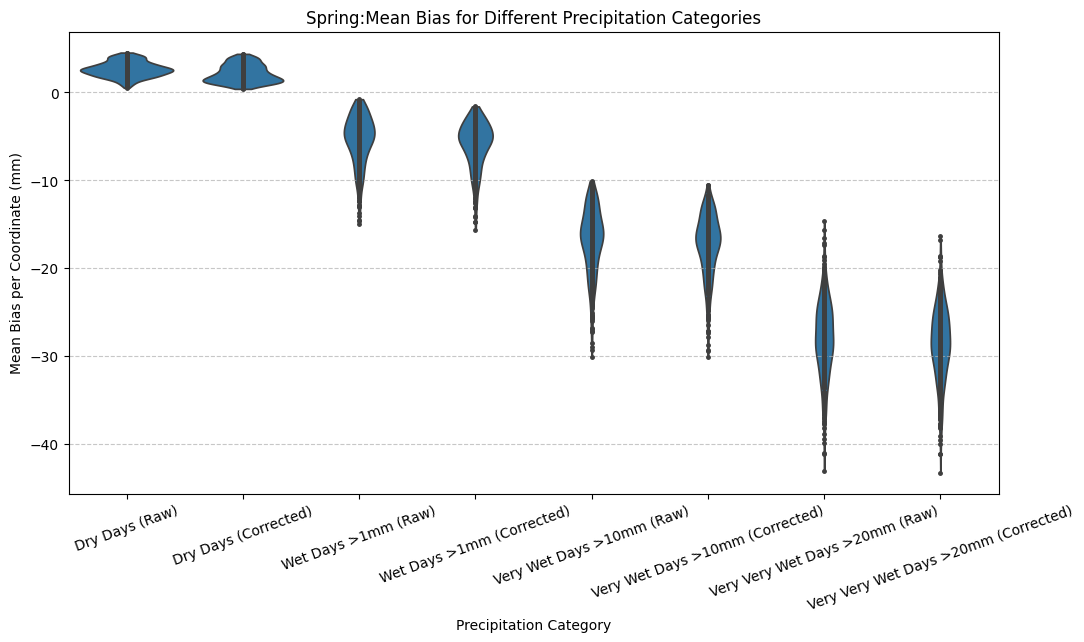

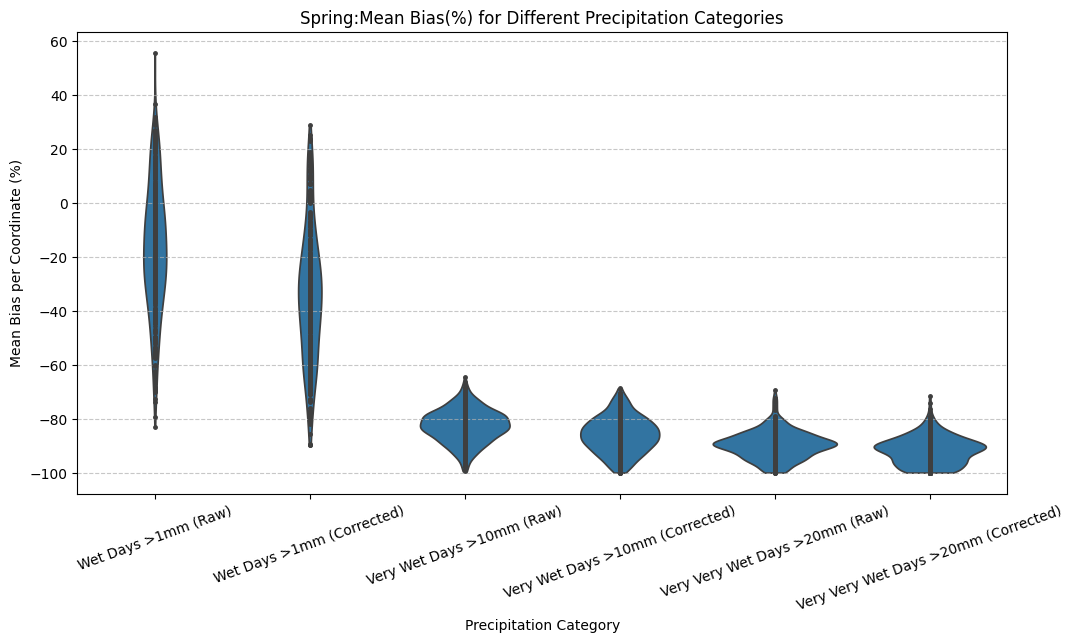

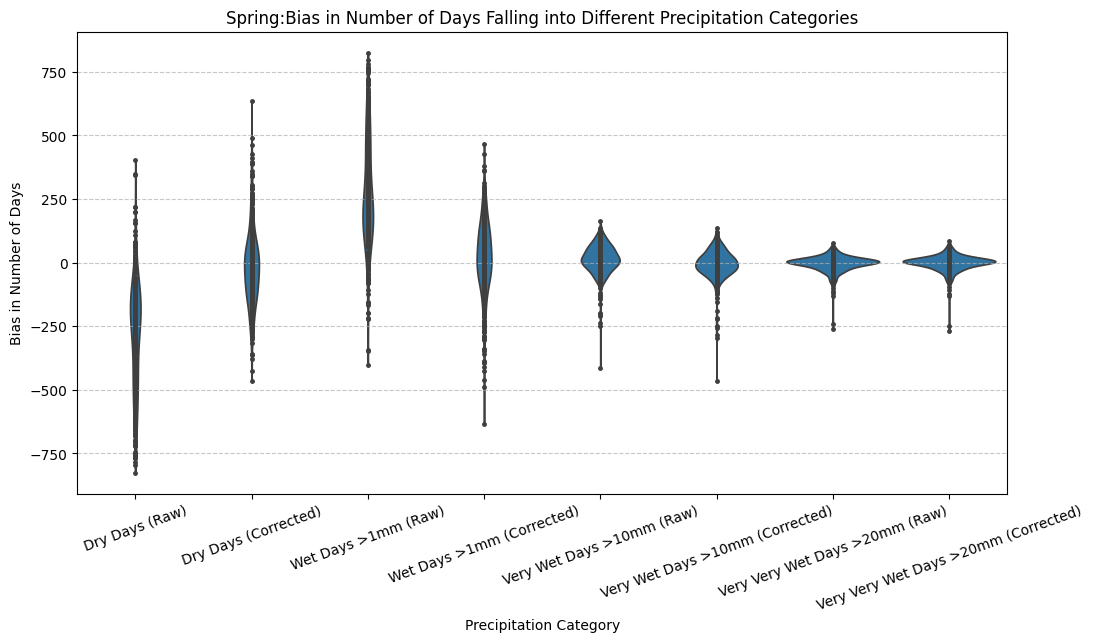

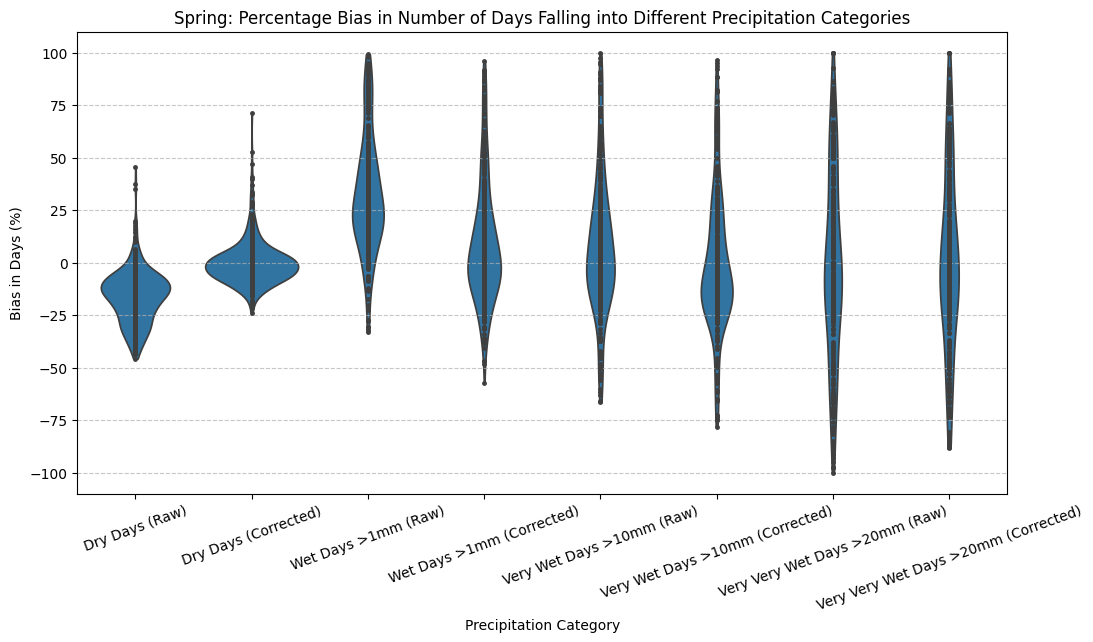

/tmp/ipykernel_602538/1269000951.py:11: RuntimeWarning: Mean of empty slice
  bias_x = np.nanmean((x - y) * mask_expanded, axis=0)  # Compute mean bias location-wise
/tmp/ipykernel_602538/1269000951.py:12: RuntimeWarning: Mean of empty slice
  bias_xt = np.nanmean((xt - y) * mask_expanded, axis=0)
/tmp/ipykernel_602538/1269000951.py:17: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(((x - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)  # Compute mean percentage bias location-wise
/tmp/ipykernel_602538/1269000951.py:18: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(((xt - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)


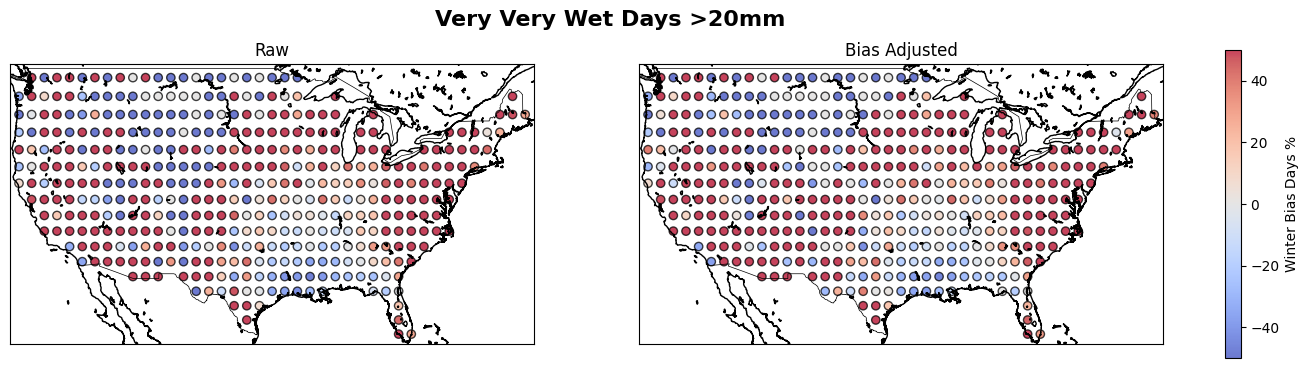

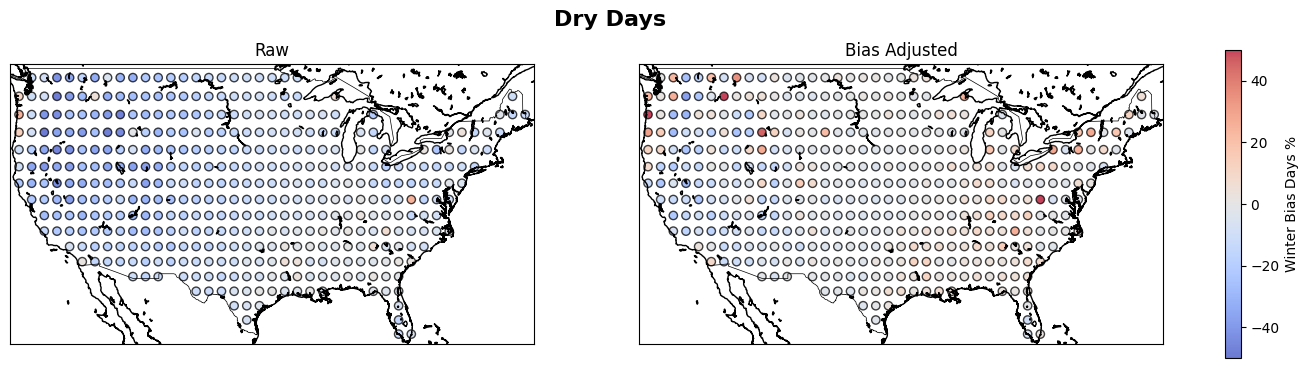

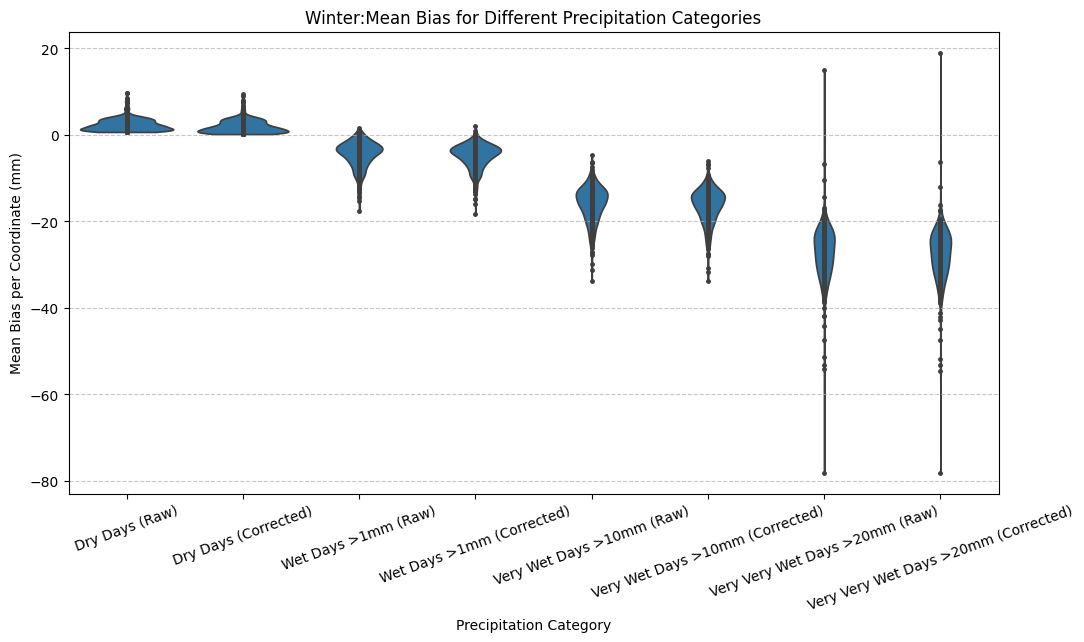

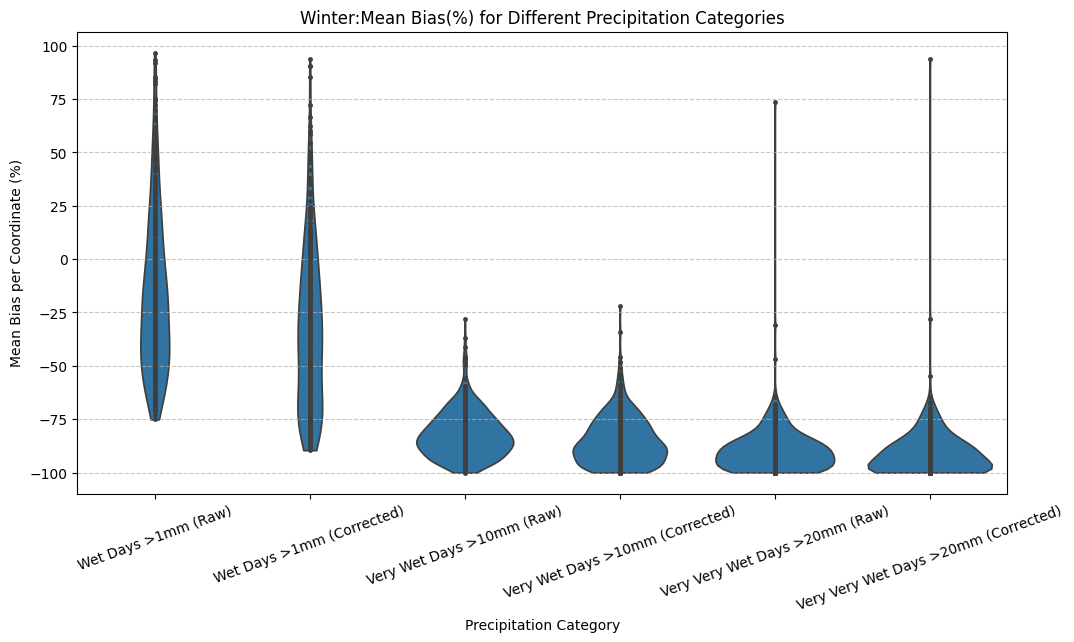

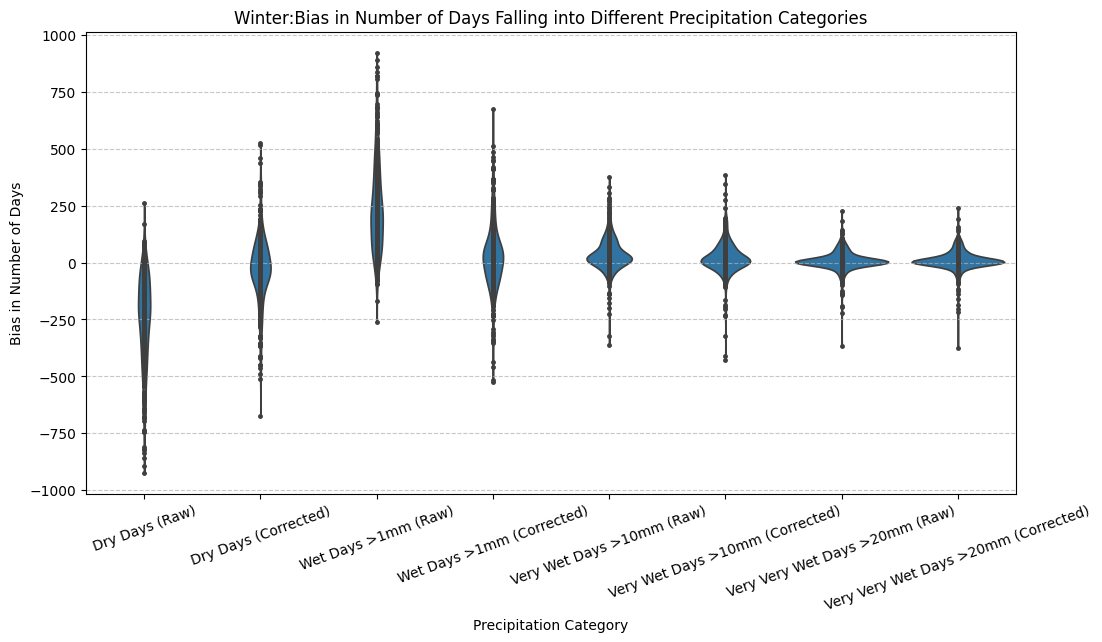

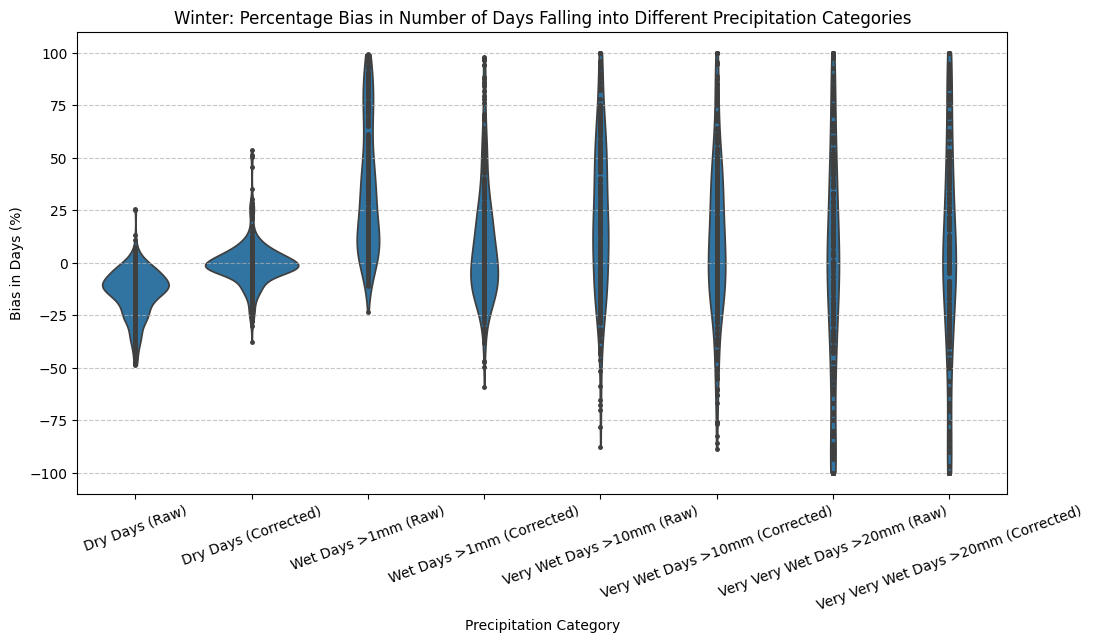

/tmp/ipykernel_602538/1269000951.py:11: RuntimeWarning: Mean of empty slice
  bias_x = np.nanmean((x - y) * mask_expanded, axis=0)  # Compute mean bias location-wise
/tmp/ipykernel_602538/1269000951.py:12: RuntimeWarning: Mean of empty slice
  bias_xt = np.nanmean((xt - y) * mask_expanded, axis=0)
/tmp/ipykernel_602538/1269000951.py:17: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(((x - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)  # Compute mean percentage bias location-wise
/tmp/ipykernel_602538/1269000951.py:18: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(((xt - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)


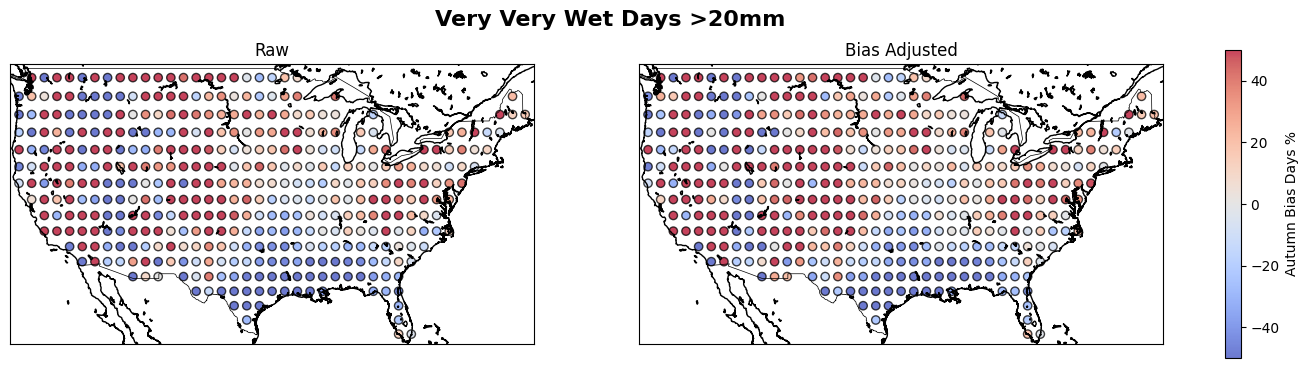

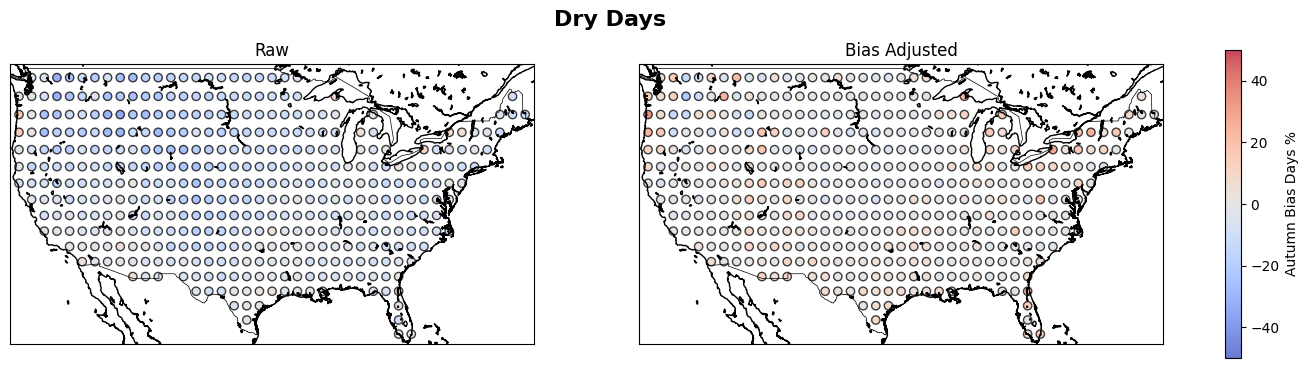

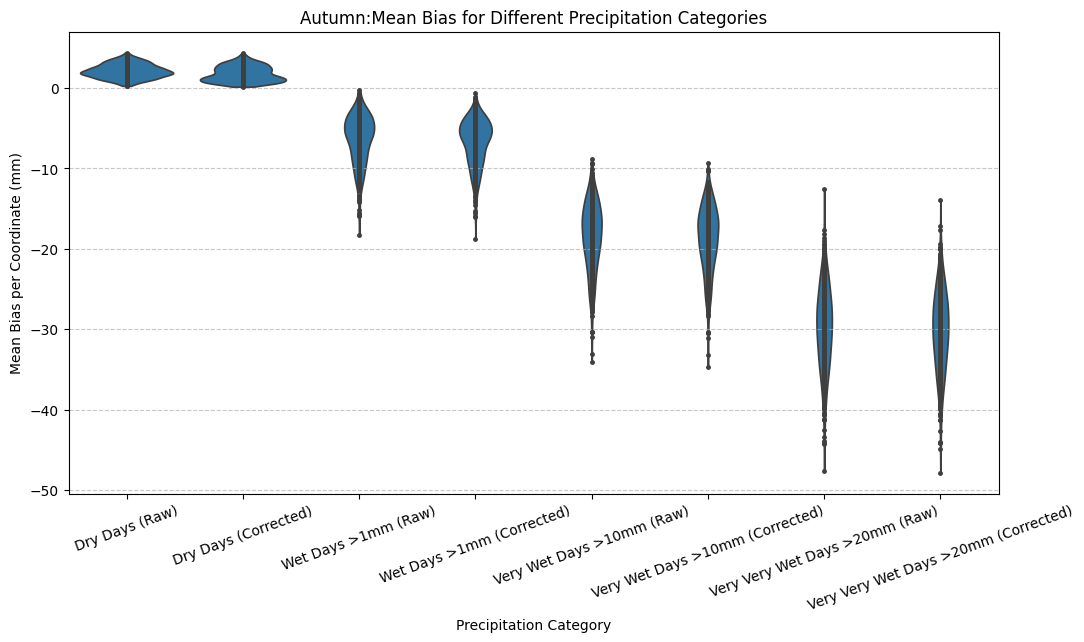

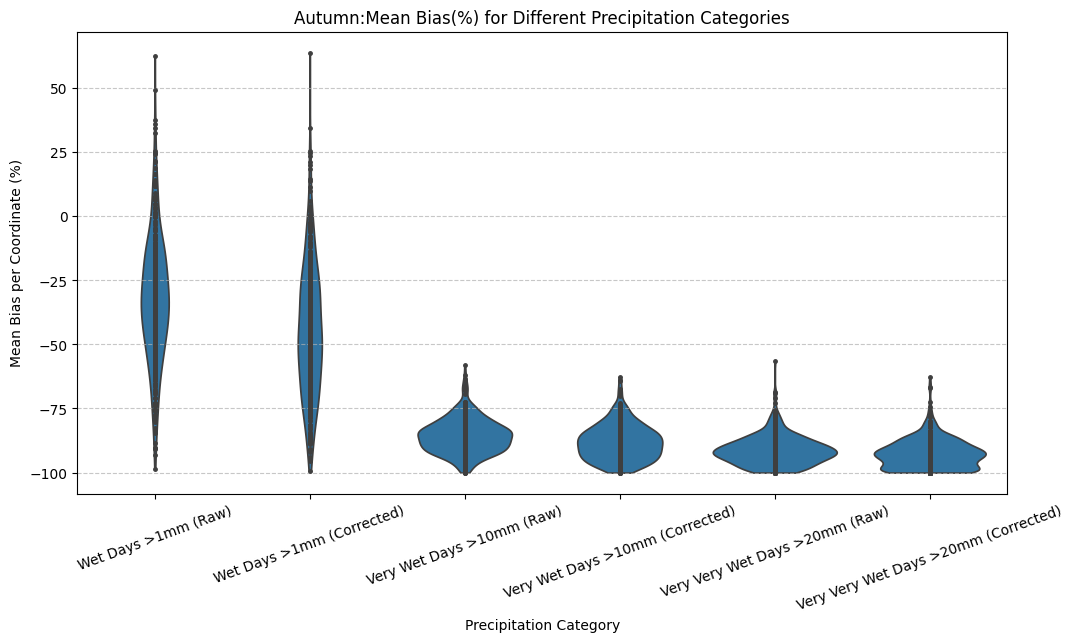

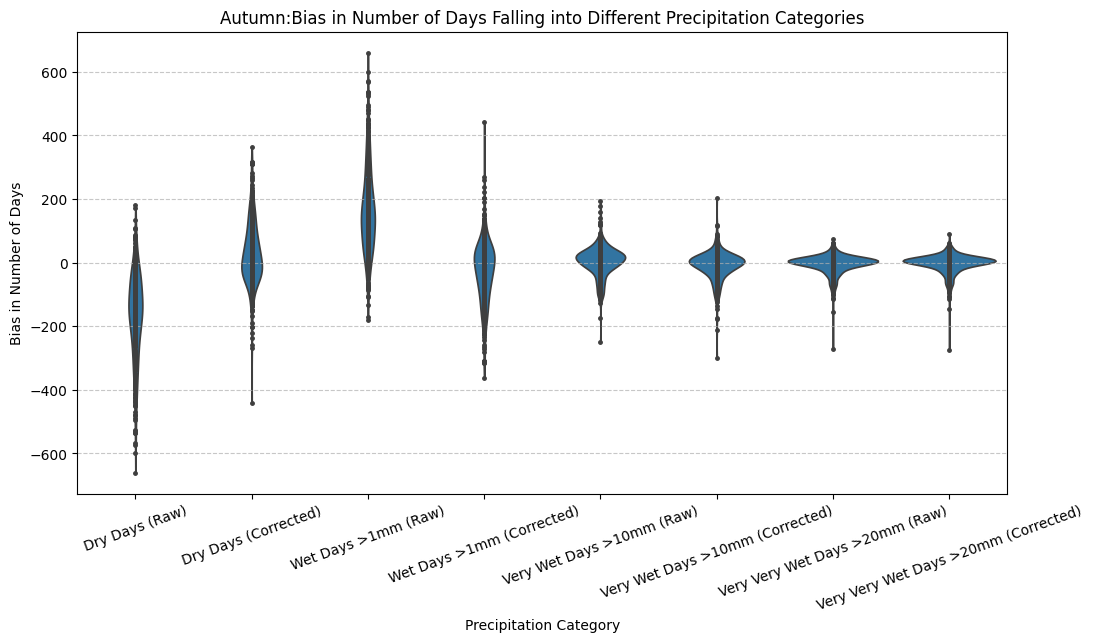

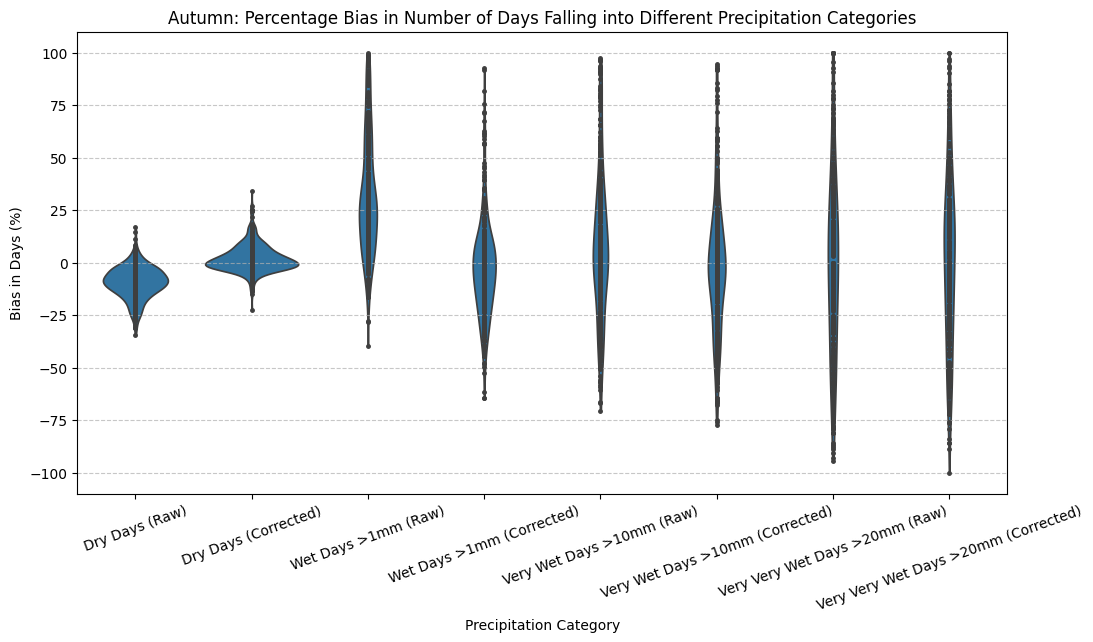

/tmp/ipykernel_602538/1269000951.py:11: RuntimeWarning: Mean of empty slice
  bias_x = np.nanmean((x - y) * mask_expanded, axis=0)  # Compute mean bias location-wise
/tmp/ipykernel_602538/1269000951.py:12: RuntimeWarning: Mean of empty slice
  bias_xt = np.nanmean((xt - y) * mask_expanded, axis=0)
/tmp/ipykernel_602538/1269000951.py:17: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(((x - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)  # Compute mean percentage bias location-wise
/tmp/ipykernel_602538/1269000951.py:18: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(((xt - y) / (y + 1e-6)) * 100 * mask_expanded, axis=0)


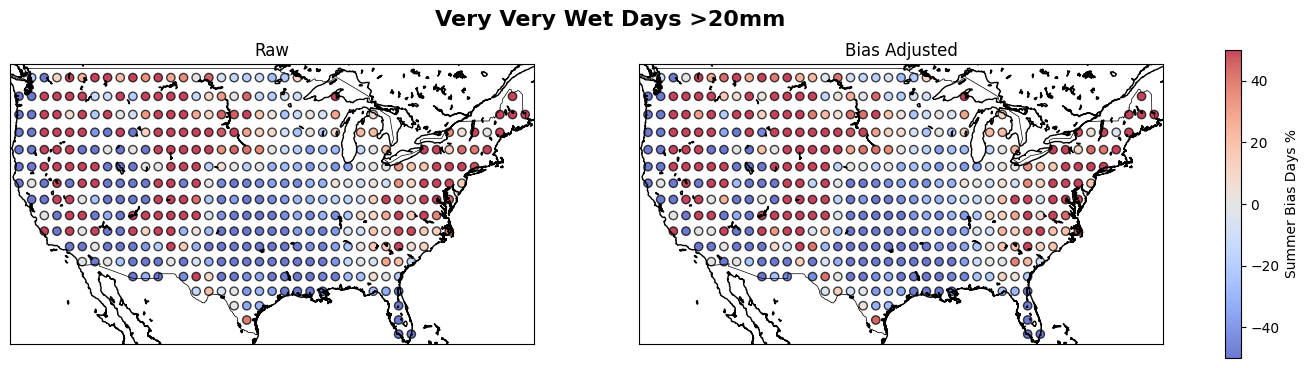

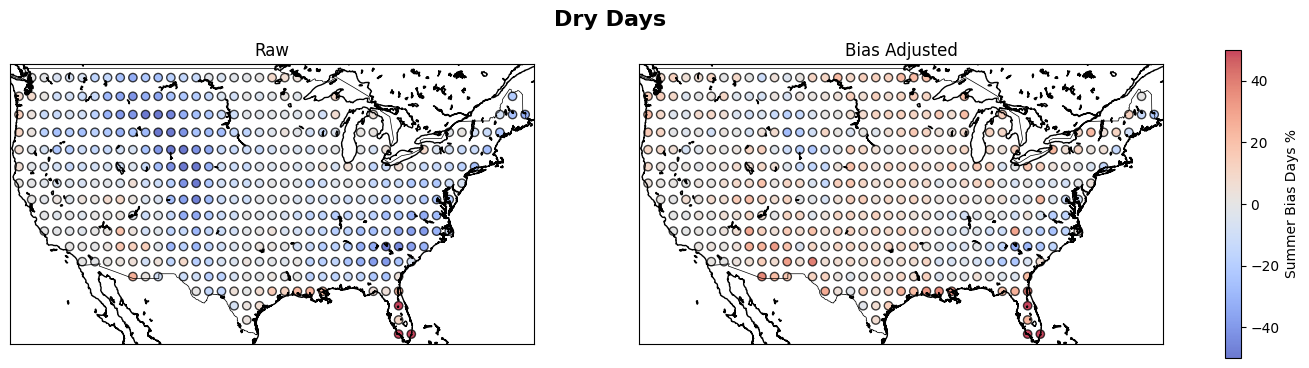

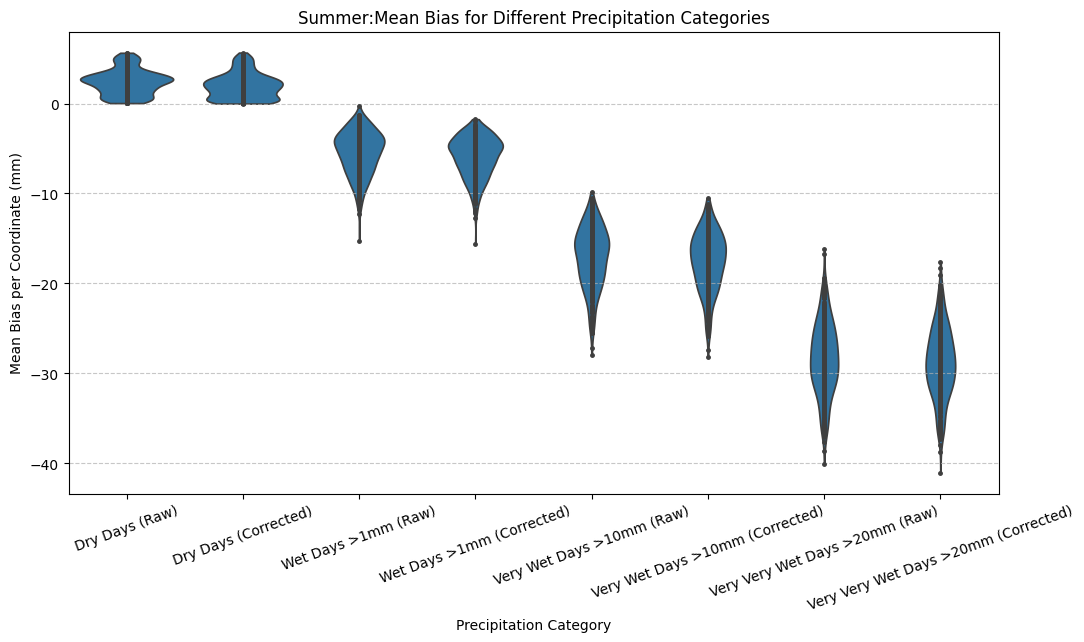

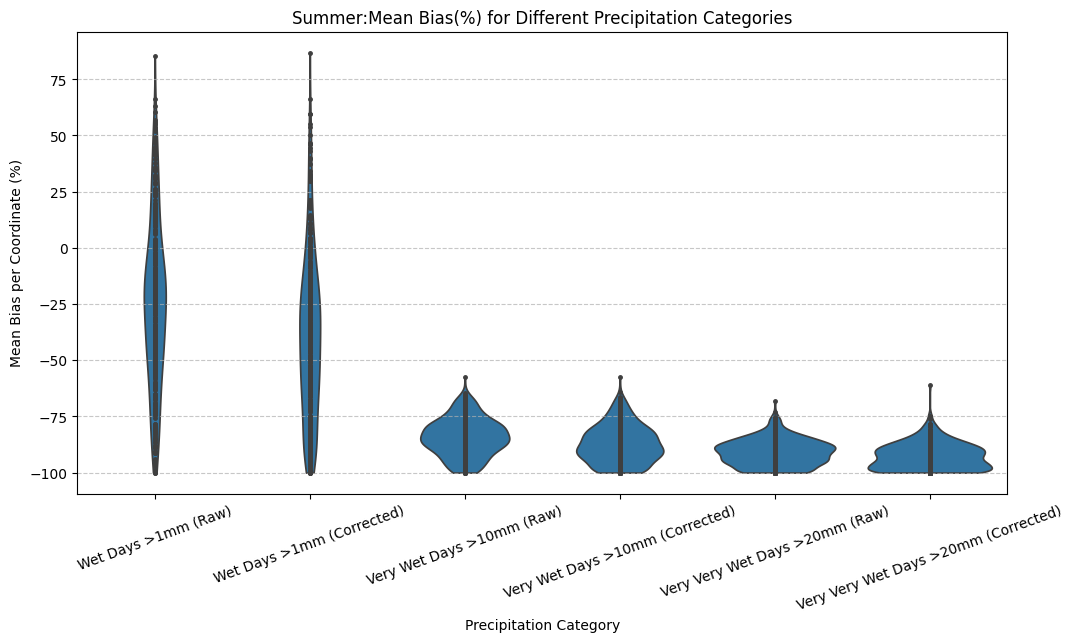

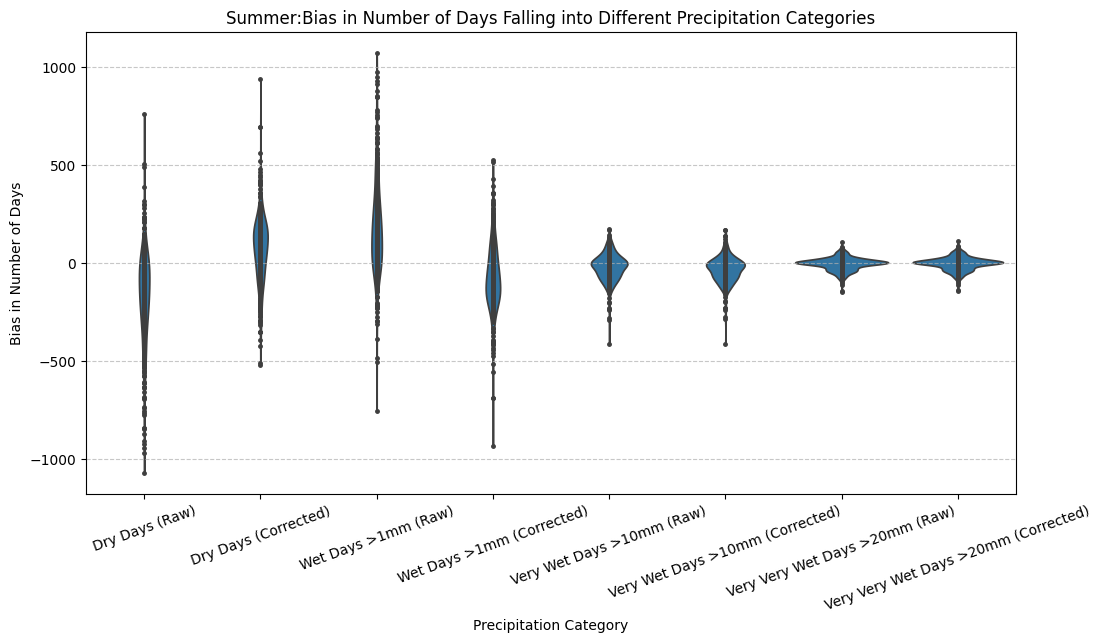

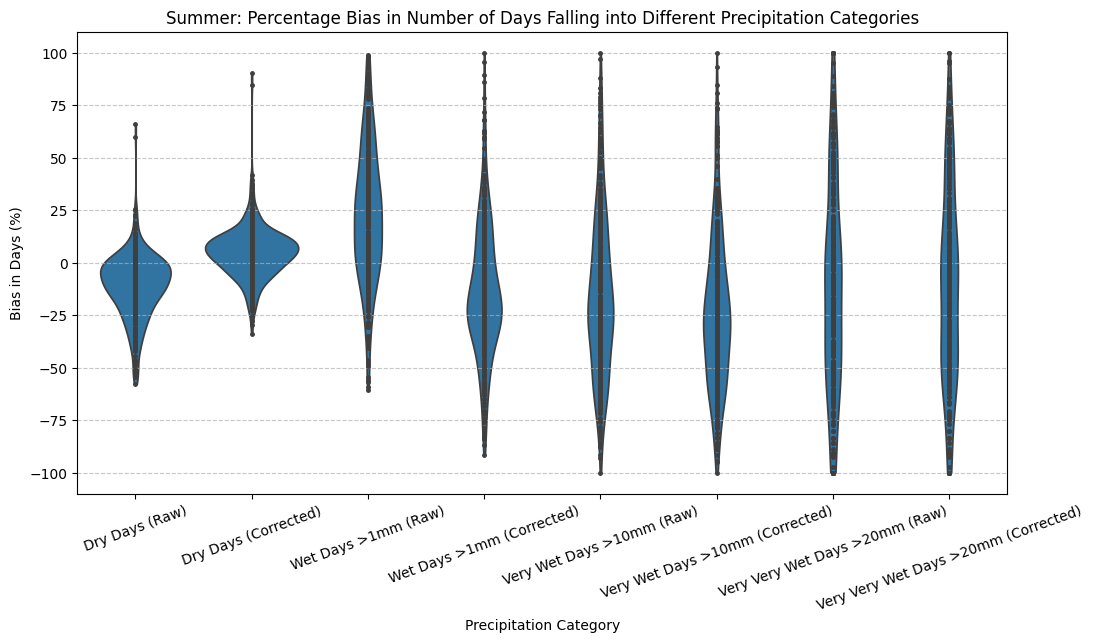

In [ ]:
for season in ['Spring', 'Winter', 'Autumn', 'Summer']:
    x_s_s = x_s[season]
    y_s_s = y_s[season]
    xt_s_s = xt_s[season]

    # Compute biases
    seasonal_mean_biases = get_mean_biases(x_s_s, y_s_s, xt_s_s)
    seasonal_day_biases = get_day_biases(x_s_s, y_s_s, xt_s_s)
    seasonal_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, xt_s_s)
    seasonal_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, xt_s_s)

    
    plot_spatial_bias(valid_coords, seasonal_day_bias_percentages, 'Very Very Wet Days >20mm', label= f'{season} Bias Days %', vmin=-50, vmax=50)
    plot_spatial_bias(valid_coords, seasonal_day_bias_percentages, 'Dry Days', label= f'{season} Bias Days %', vmin=-50, vmax=50)


    plot_violin_bias(seasonal_mean_biases, "Bias Value", "Mean Bias per Coordinate (mm)", f"{season}:Mean Bias for Different Precipitation Categories")
    plot_violin_bias(seasonal_mean_bias_percentages, "Bias Value (%)", "Mean Bias per Coordinate (%)", f"{season}:Mean Bias(%) for Different Precipitation Categories", remove_outlier=True)
    plot_violin_bias(seasonal_day_biases, "Bias in Days", "Bias in Number of Days", f"{season}:Bias in Number of Days Falling into Different Precipitation Categories")
    plot_violin_bias(seasonal_day_bias_percentages, "Bias in Days (%)", "Bias in Days (%)", f"{season}: Percentage Bias in Number of Days Falling into Different Precipitation Categories",  remove_outlier=True)
